<a href="https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a custom object detection model with TensorFlow Lite Model Maker

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) to train a custom object detection model to detect Android figurines and how to put the model on a Raspberry Pi.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.


## Preparation

### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [ ]:
!pip install -q packaging~=20.9
!pip install -q tflite-model-maker
!pip install -q tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 764.8 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 26.8 MB/s eta

Import the required packages.

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


### Prepare the dataset

This dataset contains about 70 images of 2 type of Android figurines: an Android and an Android pig. This is an example image from the dataset.

![android_figurine_sample.jpg](https://storage.googleapis.com/download.tensorflow.org/example_images/android_figurine_sample.jpg)

We start with downloading the dataset.

In [ ]:
!wget https://github.com/igoxy/tensorflow-legos/raw/main/images-jpg.zip
!unzip -q images-jpg.zip

--2023-03-26 22:44:30--  https://github.com/igoxy/tensorflow-legos/raw/main/images-jpg.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/igoxy/tensorflow-legos/main/images-jpg.zip [following]
--2023-03-26 22:44:30--  https://raw.githubusercontent.com/igoxy/tensorflow-legos/main/images-jpg.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6086210 (5.8M) [application/zip]
Saving to: ‘images-jpg.zip’

images-jpg.zip      100%[===================>]   5.80M  --.-KB/s    in 0.02s   

2023-03-26 22:44:31 (273 MB/s) - ‘images-jpg.zip’ saved [6086210/6086210]



## Train the object detection model

### Step 1: Load the dataset

* Images in `train_data` is used to train the custom object detection model.
* Images in `val_data` is used to check if the model can generalize well to new images that it hasn't seen before.

In [ ]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'images-jpg/train',
    'images-jpg/train',
    ['lego']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'images-jpg/validate',
    'images-jpg/validate',
    ['lego']
)
print(val_data)

### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite0 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you.

In [ ]:
spec = model_spec.get('efficientdet_lite0')

### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=val_data) #epochs=20 padrão

Epoch 1/5
229/229 [==============================] - 87s 189ms/step - det_loss: 0.6967 - cls_loss: 0.3845 - box_loss: 0.0062 - reg_l2_loss: 0.0632 - loss: 0.7599 - learning_rate: 0.0065 - gradient_norm: 4.2883 - val_det_loss: 0.3226 - val_cls_loss: 0.1814 - val_box_loss: 0.0028 - val_reg_l2_loss: 0.0634 - val_loss: 0.3860
Epoch 2/5
229/229 [==============================] - 39s 172ms/step - det_loss: 0.3141 - cls_loss: 0.1866 - box_loss: 0.0025 - reg_l2_loss: 0.0634 - loss: 0.3775 - learning_rate: 0.0034 - gradient_norm: 3.6061 - val_det_loss: 0.2297 - val_cls_loss: 0.1238 - val_box_loss: 0.0021 - val_reg_l2_loss: 0.0635 - val_loss: 0.2932
Epoch 3/5
229/229 [==============================] - 42s 185ms/step - det_loss: 0.2485 - cls_loss: 0.1555 - box_loss: 0.0019 - reg_l2_loss: 0.0635 - loss: 0.3119 - learning_rate: 0.0016 - gradient_norm: 3.0471 - val_det_loss: 0.1757 - val_cls_loss: 0.1016 - val_box_loss: 0.0015 - val_reg_l2_loss: 0.0635 - val_loss: 0.2392
Epoch 4/5
229/229 [=========

### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the 10 images in the validation dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 10 images in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [ ]:
model.evaluate(val_data)

2/2 [==============================] - 18s 6s/step



{'AP': 0.7622365,
 'AP50': 0.96380866,
 'AP75': 0.9344683,
 'APs': 0.460717,
 'APm': 0.81970555,
 'APl': 0.82833034,
 'ARmax1': 0.76111114,
 'ARmax10': 0.82222223,
 'ARmax100': 0.8240741,
 'ARs': 0.59411764,
 'ARm': 0.86567163,
 'ARl': 0.87083334,
 'AP_/lego': 0.7622365}

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on Raspberry Pi CPU and also compatible with the Google Coral EdgeTPU.

In [ ]:
from tflite_model_maker.object_detector import DataLoader

In [ ]:
config = QuantizationConfig.for_int8(val_data)

In [ ]:
model.export(export_dir='.', tflite_filename='lego.tflite') #, quantization_config=config)



---



### Step 6:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('lego.tflite', val_data)

100/100 [==============================] - 276s 3s/step



{'AP': 1.4246029e-06,
 'AP50': 7.1230143e-06,
 'AP75': 0.0,
 'APs': 0.0,
 'APm': 1.4043958e-05,
 'APl': 0.0,
 'ARmax1': 0.0,
 'ARmax10': 0.0018518518,
 'ARmax100': 0.0018518518,
 'ARs': 0.0,
 'ARm': 0.0029850747,
 'ARl': 0.0,
 'AP_/lego': 1.4246029e-06}

In [ ]:
interpreter = tf.lite.Interpreter(model_path='lego.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.float32'>


In [ ]:
# Download the TFLite model to your local computer.
from google.colab import files
files.download('android.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test the Android figurine detection model

After training the model, let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

In [ ]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)

    print(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

25.0


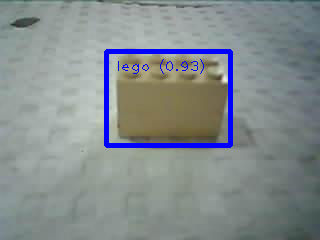

In [ ]:
#@title Run object detection and show the detection results

from PIL import Image

INPUT_IMAGE_URL = "http://download.tensorflow.org/example_images/android_figurine.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}
TFLITE_MODEL_PATH = "lego.tflite" #@param {type:"string"}

TEMP_FILE = '/tmp/image.png'

#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
#image = Image.open(TEMP_FILE).convert('RGB')
image = Image.open('lego-t11.jpg').convert('RGB')
#image.thumbnail((512, 512), Image.ANTIALIAS)
image.thumbnail((320, 240), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

## Compile the model for EdgeTPU

Finally, we'll compile the model using `edgetpu_compiler` so that the model can run on [Google Coral EdgeTPU](https://coral.ai/).

We start with installing the EdgeTPU compiler on Colab.

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  59000      0 --:--:-- --:--:-- --:--:-- 59000
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,398 kB]
Ign:9 https://developer.download.nvidia.com/comput

**Note:** When training the model using a custom dataset, beware that if your dataset includes more than 20 classes, you'll probably have slower inference speeds compared to if you have fewer classes. This is due to an aspect of the EfficientDet architecture in which a certain layer cannot compile for the Edge TPU when it carries more than 20 classes.

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaters](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

In [ ]:
NUMBER_OF_TPUS = 1

!edgetpu_compiler android.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 3127 ms.

Input model: android.tflite
Input size: 4.22MiB
Output model: android_edgetpu.tflite
Output size: 5.57MiB
On-chip memory used for caching model parameters: 4.21MiB
On-chip memory remaining for caching model parameters: 3.29MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: android_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.
Compilation child proces

Finally, we'll copy the metadata, including the label file, from the original TensorFlow Lite model to the EdgeTPU model.

In [ ]:
populator_dst = metadata.MetadataPopulator.with_model_file('android_edgetpu.tflite')

with open('android.tflite', 'rb') as f:
  populator_dst.load_metadata_and_associated_files(f.read())

populator_dst.populate()
updated_model_buf = populator_dst.get_model_buffer()

In [ ]:
# Download the TFLite model compiled for EdgeTPU to your local computer.
from google.colab import files
files.download('android_edgetpu.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>